In [1]:
import tensorflow as tf
physical_devices=tf.config.list_physical_devices()
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[3], True)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization, Dropout, Add
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import numpy as np

In [3]:
effnet = EfficientNetB3(input_shape = (256, 512, 3), include_top = False)

In [4]:
BATCH_SIZE=2
IMG_HEIGHT = 256
IMG_WIDTH = 512
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH, 3)

O_STRIDE_0 = 8
O_STRIDE_1 = 4
O_STRIDE_2 = 2
O_STRIDE_3 = 1

RESOLUTION_0 = (int(IMG_HEIGHT/O_STRIDE_0), int(IMG_WIDTH/O_STRIDE_0))
RESOLUTION_1 = (int(IMG_HEIGHT/O_STRIDE_1), int(IMG_WIDTH/O_STRIDE_1))
RESOLUTION_2 = (int(IMG_HEIGHT/O_STRIDE_2), int(IMG_WIDTH/O_STRIDE_2))
RESOLUTION_3 = (int(IMG_HEIGHT/O_STRIDE_3), int(IMG_WIDTH/O_STRIDE_3))

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(RESOLUTION_0, RESOLUTION_1, RESOLUTION_2, RESOLUTION_3)

ORIGINAL_RESOLUTION = [375, 1242, 3]

(32, 64) (64, 128) (128, 256) (256, 512)


In [5]:

############################kitti_stereo_dataset_without_gt_label___##############################################################
# directory = "/home/himanshu/Jupyter/Jupyter Notebook/DisparityStereo Trial1"
directory = str(os.getcwd())
train_left_dirs = tf.data.Dataset.list_files(directory + '/left_image/train/*/*', shuffle = False)
val_left_dirs = tf.data.Dataset.list_files(directory + '/left_image/validation/*', shuffle = False)
test_left_dirs = tf.data.Dataset.list_files(directory + '/left_image/val/*/*', shuffle = False)

train_right_dirs = tf.data.Dataset.list_files(directory + '/right_image/train/*/*', shuffle = False)
val_right_dirs = tf.data.Dataset.list_files(directory + '/right_image/validation/*', shuffle = False)
test_right_dirs = tf.data.Dataset.list_files(directory + '/right_image/val/*/*', shuffle = False)



In [6]:
left_val=[]
for val_left in val_left_dirs:
    val_left = val_left.numpy().decode("utf-8")
    if int(val_left[-6:-4]) == 10:
        left_val.append(val_left)
        
right_val=[]
for val_right in val_right_dirs:
    val_right = val_right.numpy().decode("utf-8")
    if int(val_right[-6:-4]) == 10:
        right_val.append(val_right)

In [7]:
left_val

['/home/himanshu/Github/Depth Estimation/left_image/validation/000000_10.png',
 '/home/himanshu/Github/Depth Estimation/left_image/validation/000001_10.png',
 '/home/himanshu/Github/Depth Estimation/left_image/validation/000002_10.png',
 '/home/himanshu/Github/Depth Estimation/left_image/validation/000003_10.png',
 '/home/himanshu/Github/Depth Estimation/left_image/validation/000004_10.png',
 '/home/himanshu/Github/Depth Estimation/left_image/validation/000005_10.png',
 '/home/himanshu/Github/Depth Estimation/left_image/validation/000006_10.png',
 '/home/himanshu/Github/Depth Estimation/left_image/validation/000007_10.png',
 '/home/himanshu/Github/Depth Estimation/left_image/validation/000008_10.png',
 '/home/himanshu/Github/Depth Estimation/left_image/validation/000009_10.png',
 '/home/himanshu/Github/Depth Estimation/left_image/validation/000010_10.png',
 '/home/himanshu/Github/Depth Estimation/left_image/validation/000011_10.png',
 '/home/himanshu/Github/Depth Estimation/left_image/

In [8]:
val_left_dirs = tf.data.Dataset.from_tensor_slices((left_val))
val_right_dirs = tf.data.Dataset.from_tensor_slices((right_val))

In [9]:
print(f"No. of Training Samples are {len(train_left_dirs)}, {len(train_right_dirs)}")
print(f"No. of Training Samples are {len(val_left_dirs)}, {len(val_right_dirs)}")

No. of Training Samples are 4200, 4200
No. of Training Samples are 200, 200


In [10]:
test_ds = tf.data.Dataset.zip((test_left_dirs, test_right_dirs))
len(test_ds)

4189

In [11]:
train_ds = tf.data.Dataset.zip((train_left_dirs, train_right_dirs))
val_ds = tf.data.Dataset.zip((val_left_dirs, val_right_dirs))

train_ds = train_ds.take(4200)
val_ds = val_ds.take(200)

In [12]:
def get_files(l_img_dir, r_img_dir):
    l_img = tf.io.read_file(l_img_dir)
    r_img = tf.io.read_file(r_img_dir)

    
    l_img = tf.io.decode_png(l_img, channels=3)
    r_img = tf.io.decode_png(r_img, channels=3)

    
    l_img = tf.cast(l_img, dtype=tf.float32)
    r_img = tf.cast(r_img, dtype=tf.float32)
    
    l_img_0 = tf.image.resize(l_img, size=RESOLUTION_0)/255.0
    r_img_0 = tf.image.resize(r_img, size=RESOLUTION_0)/255.0
    
    
    l_img_1 = tf.image.resize(l_img, size=RESOLUTION_1)/255.0
    r_img_1 = tf.image.resize(r_img, size=RESOLUTION_1)/255.0
    

    
    l_img_2 = tf.image.resize(l_img, size=RESOLUTION_2)/255.0
    r_img_2 = tf.image.resize(r_img, size=RESOLUTION_2)/255.0
    


    l_img_3 = tf.image.resize(l_img, size=RESOLUTION_3)/255.0
    r_img_3 = tf.image.resize(r_img, size=RESOLUTION_3)/255.0
    

    
    
    return  l_img_0, l_img_1, l_img_2, l_img_3, r_img_0,  r_img_1, r_img_2, r_img_3



def get_val_files(l_img_dir, r_img_dir):
    l_img = tf.io.read_file(l_img_dir)
    r_img = tf.io.read_file(r_img_dir)

    
    l_img = tf.io.decode_png(l_img, channels=3)
    r_img = tf.io.decode_png(r_img, channels=3)

    
    l_img = tf.cast(l_img, dtype=tf.float32)
    r_img = tf.cast(r_img, dtype=tf.float32)

    
    l_img_0 = tf.image.resize(l_img, size=RESOLUTION_0)/255.0
    r_img_0 = tf.image.resize(r_img, size=RESOLUTION_0)/255.0
    
    l_img_1 = tf.image.resize(l_img, size=RESOLUTION_1)/255.0
    r_img_1 = tf.image.resize(r_img, size=RESOLUTION_1)/255.0
    
    l_img_2 = tf.image.resize(l_img, size=RESOLUTION_2)/255.0
    r_img_2 = tf.image.resize(r_img, size=RESOLUTION_2)/255.0


    l_img_3 = tf.image.resize(l_img, size=RESOLUTION_3)/255.0
    r_img_3 = tf.image.resize(r_img, size=RESOLUTION_3)/255.0
    return  l_img_0, l_img_1, l_img_2, l_img_3, r_img_0,  r_img_1, r_img_2, r_img_3

train_ds = train_ds.map(get_files, num_parallel_calls = AUTOTUNE)

val_ds = val_ds.map(get_val_files, num_parallel_calls = AUTOTUNE)



In [13]:
test_ds = test_ds.map(get_files, num_parallel_calls = AUTOTUNE)

Left Image


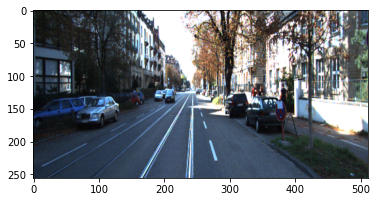

Right Image


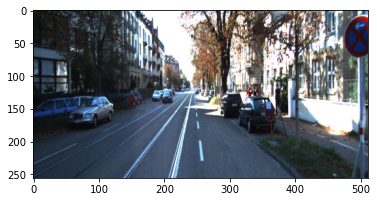

Left Image


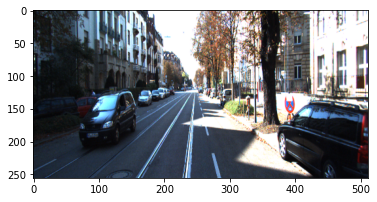

Right Image


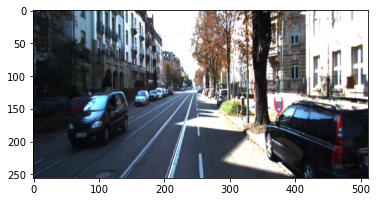

In [14]:
# for _,_, _, left_img, _, _,_,right_img, gt_label in train_0_ds.take(1):
for _,_, _, left_img, _, _,_,right_img in train_ds.take(1):
    left_img = tf.cast(left_img, dtype = tf.float32)
    right_img = tf.cast(right_img, dtype =tf.float32)
    print("Left Image")
    plt.imshow(left_img)
    plt.show()
    print("Right Image")
    plt.imshow(right_img)
    plt.show()

for _,_, _, left_img, _, _,_,right_img in val_ds.take(1):
    left_img = tf.cast(left_img, dtype = tf.float32)
    right_img = tf.cast(right_img, dtype =tf.float32)
    print("Left Image")
    plt.imshow(left_img)
    plt.show()
    print("Right Image")
    plt.imshow(right_img)
    plt.show()


In [15]:
def configure_for_performance(ds, train="no"):
    if train=="no":
        ds = ds.cache(filename="val_cache")
    else:
        ds = ds.cache(filename = f"train_{int(train)}_cache")
    ds = ds.shuffle(buffer_size=40)
    ds = ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds
    
train_ds = configure_for_performance(train_ds, train=1)
val_ds = configure_for_performance(val_ds)

In [16]:
test_ds = configure_for_performance(test_ds, train=2)

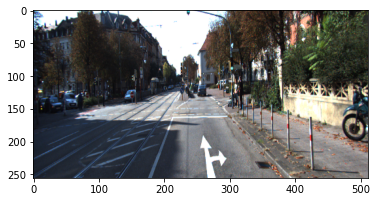

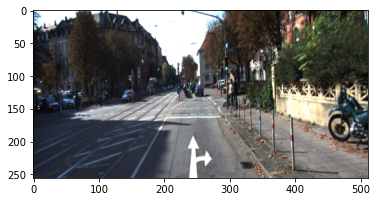

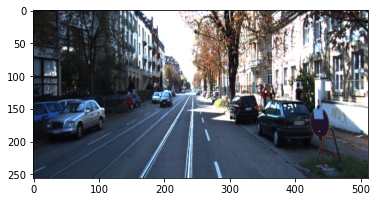

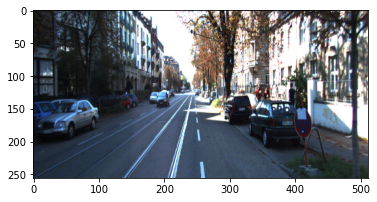

In [17]:
for _, _, _, left_img,_,_,_, right_img in train_ds.take(1):
    for index in range(BATCH_SIZE):
        left_img = tf.cast(left_img, dtype=tf.float32)
        right_img = tf.cast(right_img, dtype=tf.float32)
        dx, dy = tf.image.image_gradients(tf.reduce_mean(left_img, axis=3, keepdims=True))
        plt.imshow(left_img[index])
        plt.show()
        plt.imshow(right_img[index])
        plt.show()

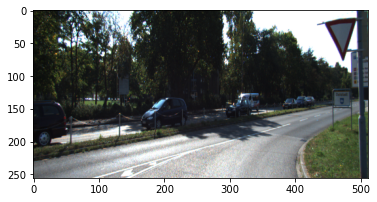

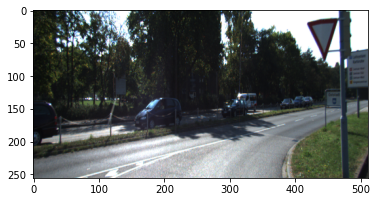

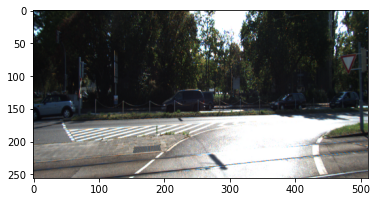

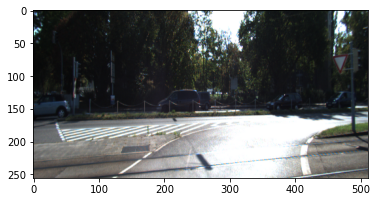

In [18]:
for _, _, _, left_img,_,_,_, right_img in test_ds.take(1):
    for index in range(BATCH_SIZE):
        left_img = tf.cast(left_img, dtype=tf.float32)
        right_img = tf.cast(right_img, dtype=tf.float32)
        dx, dy = tf.image.image_gradients(tf.reduce_mean(left_img, axis=3, keepdims=True))
        plt.imshow(left_img[index])
        plt.show()
        plt.imshow(right_img[index])
        plt.show()

In [19]:
x_input = Input((256, 512, 3))

encoder=  EfficientNetB3(input_tensor=x_input, input_shape=(256, 512, 3), include_top = False, weights=None)
# encoder.trainable = False
skip_connection = ["block5a_expand_activation", "block4a_expand_activation","block3a_expand_activation","block2a_expand_activation"]
features = encoder.get_layer(skip_connection[0]).output


x = UpSampling2D((2, 2))(features)
x = Conv2D(360, (3, 3), kernel_initializer="he_normal", activation="elu", padding="same")(x)

x = tf.concat([x, encoder.get_layer(skip_connection[1]).output], axis=3)
x = Conv2D(360, (3, 3), kernel_initializer="he_normal", activation="elu", padding="same")(x)
disp_0 = Conv2D(2, (3, 3), padding="same")(x)
disp_0 = tf.nn.sigmoid(disp_0)*0.3
up_disp_0 = UpSampling2D((2, 2))(disp_0)

x = UpSampling2D((2, 2))(x)
x = Conv2D(180, (3, 3), kernel_initializer="he_normal", activation="elu", padding="same")(x)
x = tf.concat([x, up_disp_0, encoder.get_layer(skip_connection[2]).output], axis=3)
x = Conv2D(180, (3, 3), kernel_initializer="he_normal", activation="elu", padding="same")(x)
disp_1 = Conv2D(2, (3, 3), padding="same")(x)
disp_1 = tf.nn.sigmoid(disp_1)*0.3
up_disp_1 = UpSampling2D((2, 2))(disp_1)

x = UpSampling2D((2, 2))(x)
x = Conv2D(90, (3, 3), kernel_initializer="he_normal", activation="elu", padding="same")(x)
# x = Conv2D(90, (3, 3), kernel_initializer="he_normal", activation="elu", padding="same")(x)
x = tf.concat([x, up_disp_1, encoder.get_layer(skip_connection[3]).output], axis=3)
x = Conv2D(90, (3, 3), kernel_initializer="he_normal", activation="elu", padding="same")(x)
disp_2 = Conv2D(2, (3, 3), padding="same")(x)
disp_2 = tf.nn.sigmoid(disp_2)*0.3
up_disp_2 = UpSampling2D((2, 2))(disp_2)


x = UpSampling2D((2, 2))(x)
x = Conv2D(45, (3, 3), kernel_initializer="he_normal", activation="elu", padding="same")(x)
# x = Conv2D(45, (3, 3), kernel_initializer="he_normal", activation="elu", padding="same")(x)  ##Does not work##
x = tf.concat([x, up_disp_2], axis=3)
x = Conv2D(45, (3, 3), kernel_initializer="he_normal", activation="elu", padding="same")(x)
disp_3 = Conv2D(2, (3, 3), padding="same")(x)
disp_3 = tf.nn.sigmoid(disp_3)*0.3


disparity = [disp_0, disp_1, disp_2, disp_3]
model = Model(inputs= x_input, outputs=disparity)


In [20]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 256, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 256, 512, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 513, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

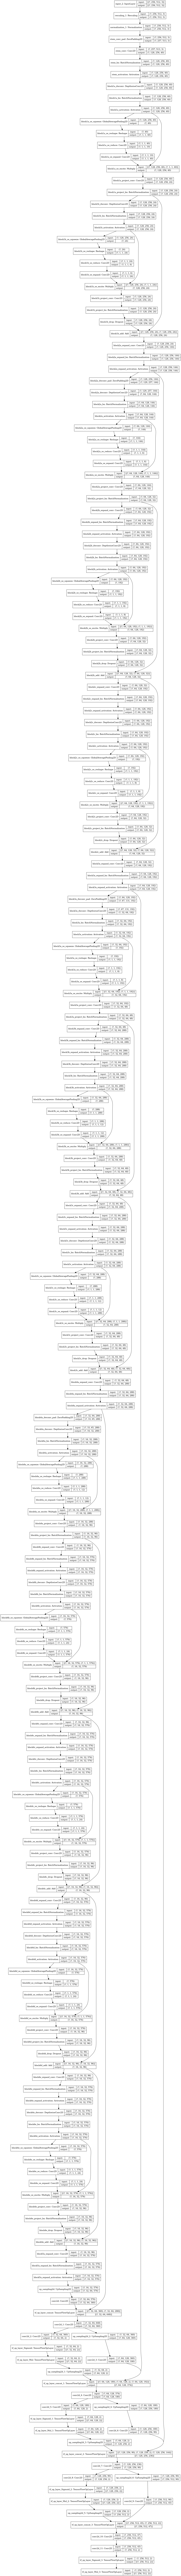

In [21]:
tf.keras.utils.plot_model(model, to_file = "my_model.png", show_shapes = True)

In [22]:
def bilinear_sampler(img, x_offset): 
    def repeat_fn(x, n_repeats):
        with tf.name_scope("repeat"):
            rep = tf.tile(tf.expand_dims(x, 1), [1, n_repeats])
            return tf.reshape(rep, [-1])
    
    def interpolate_fn(img, x_t_flat, y_t_flat, warp_mode = "border"):
        with tf.name_scope("interpolate"):
            _edge_size = 0
            if warp_mode == "border":
                _edge_size = 1
                img = tf.pad(img, [[0, 0], [1, 1], [1, 1], [0, 0]], mode = "CONSTANT")
                x_t_flat = x_t_flat + _edge_size
                y_t_flat = y_t_flat + _edge_size
            elif warp_mode == "edge":
                _edge_size = 0
            else:
                return None
            x_t_flat = tf.clip_by_value(x_t_flat, 0.0, width_f - 1 + 2*_edge_size)
            
            x0_f = tf.floor(x_t_flat)
            y0_f = tf.floor(y_t_flat)
            x1_f = x0_f + 1
            
            x0 = tf.cast(x0_f, dtype = tf.int32)
            y0 = tf.cast(y0_f, dtype = tf.int32)
            x1 = tf.cast(tf.clip_by_value(x1_f,0.0, width_f - 1 + 2*_edge_size), dtype = tf.int32)
            
            dim2 = (w + 2*_edge_size)
            dim1 = (w + 2*_edge_size) * (h + 2 * _edge_size)
            base = repeat_fn(tf.range(num_batch)* dim1, h * w)
            base_y0 = base + y0 * dim2
            idx_l = base_y0 + x0
            idx_r = base_y0 + x1
            
            img_flat = tf.reshape(img, tf.stack([-1, channels]))
            pix_l = tf.gather(img_flat, idx_l)
            pix_r = tf.gather(img_flat, idx_r)
            
            weight_l = tf.expand_dims(x1_f - x_t_flat, 1)
            weight_r = tf.expand_dims(x_t_flat - x0_f, 1)
            return weight_l * pix_l + weight_r * pix_r
             
    
    def transform_fn(img, x_offset):
        with tf.name_scope("transform"):
            '''creating grid (x_t, y_t)'''
            x_t, y_t = tf.meshgrid(tf.linspace(0.0, width_f - 1.0, w),
                                   tf.linspace(0.0, height_f - 1.0, h))
            x_t_flat = tf.reshape(x_t, [1, -1])
            y_t_flat = tf.reshape(y_t, [1, -1])            
            x_t_flat = tf.tile(x_t_flat, tf.stack([num_batch, 1]))
            y_t_flat = tf.tile(y_t_flat, tf.stack([num_batch, 1]))
            x_t_flat = tf.reshape(x_t_flat, [-1])
            y_t_flat = tf.reshape(y_t_flat, [-1])
            x_t_flat = x_t_flat + tf.reshape(x_offset, [-1]) * width_f
            
            input_transformed = interpolate_fn(img, x_t_flat, y_t_flat)
            
            output = tf.reshape(input_transformed,
                                tf.stack([num_batch, h, w, channels]))
            return output
            
    with tf.name_scope("mains"):
        num_batch, h, w, channels = img.shape
        height_f = tf.cast(h, dtype=tf.float32)
        width_f = tf.cast(w, dtype=tf.float32)
        output = transform_fn(img, x_offset)
        return output
    
def SSIM(x, y):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2
    
    mu_x = tf.nn.avg_pool2d(x, 3, 1, "VALID")
    mu_y = tf.nn.avg_pool2d(y, 3, 1, "VALID")
    
    sigma_x = tf.nn.avg_pool2d(x**2, 3, 1, "VALID")
    sigma_y = tf.nn.avg_pool2d(y**2, 3, 1, "VALID")
    sigma_xy = tf.nn.avg_pool2d(x*y , 3, 1, "VALID")
    
    SSIM_n = (2*mu_x*mu_y + C1)*(2*sigma_xy + C2)
    SSIM_d = (mu_x ** 2 + mu_y **2 + C1)*(sigma_x + sigma_y + C2)
    SSIM = SSIM_n/SSIM_d
    return tf.clip_by_value((1-SSIM)/2, 0, 1)

def generate_left_image(image, disp):
    return bilinear_sampler(image, -disp)

def generate_right_image(image, disp):
    return bilinear_sampler(image, disp)

In [23]:
def loss_fn(left_images, right_images, pred):
    N = len(left_images)
    alpha = 0.85
    alpha_ds = 0.1
    disparity_left = [tf.expand_dims(pred[i][:,:,:,0], axis=3) for i in range(N)]
    disparity_right = [tf.expand_dims(pred[i][:,:,:,1], axis=3) for i in range(N)]
    
    #Image Generation
    left_image_est = [generate_left_image(right_images[i], disparity_left[i]) for i in range(N)]
    right_image_est = [generate_right_image(left_images[i], disparity_right[i]) for i in range(N)]
    
    #L1 Reconstruction loss
    left_l1_loss = [tf.abs(left_images[i] - left_image_est[i]) for i in range(N)]
    left_l1_loss = [tf.reduce_mean(left_l1_loss[i]) for i in range(N)]
    right_l1_loss = [tf.abs(right_images[i] - right_image_est[i]) for i in range(N)]
    right_l1_loss = [tf.reduce_mean(right_l1_loss[i]) for i in range(N)]
    
    #Structural similarity index
    left_ssim_loss = [SSIM(left_images[i], left_image_est[i]) for i in range(N)]
    left_ssim_loss = [tf.reduce_mean(left_ssim_loss[i]) for i in range(N)]
    right_ssim_loss = [SSIM(right_images[i], right_image_est[i]) for i in range(N)]
    right_ssim_loss = [tf.reduce_mean(right_ssim_loss[i]) for i in range(N)]
    print(left_ssim_loss[-1])
    #Appearence Loss
    left_appearence_loss = [alpha * left_ssim_loss[i]+ (1 - alpha) * left_l1_loss[i] for i in range(N)]                                                                 
    right_appearence_loss = [alpha * right_ssim_loss[i]+ (1 - alpha) * right_l1_loss[i] for i in range(N)]
    appearence_loss = [left_appearence_loss[i]+right_appearence_loss[i] for i in range(N)]
#     appearence_loss = tf.add_n(left_appearence_loss+ right_appearence_loss)
    
    #Image Gradients
    grads_left_image = [tf.image.image_gradients(left_images[i]) for i in range(N)]
    grads_right_image = [tf.image.image_gradients(right_images[i]) for i in range(N)]
    
    #Disparity Gradients 
    grads_disp_left = [tf.abs(tf.image.image_gradients(disparity_left[i])) for i in range(N)]
    grads_disp_right = [tf.abs(tf.image.image_gradients(disparity_right[i])) for i in range(N)]
    
    #Smoothness Loss
    left_smoothness_x = [grads_disp_left[i][0]*tf.exp(-tf.reduce_mean(grads_left_image[i][0], axis=3, keepdims=True)) for i in range(N)]                           
    left_smoothness_y = [grads_disp_left[i][1]*tf.exp(-tf.reduce_mean(grads_left_image[i][1], axis=3, keepdims=True)) for i in range(N)]                           
    left_smoothness = [left_smoothness_x[i] + left_smoothness_y[i] for i in range(N)] 
    left_smoothness = [tf.reduce_mean(tf.abs(left_smoothness[i]))/2.0 ** (N-i-1) for i in range(N)]
    
    right_smoothness_x = [grads_disp_right[i][0]*tf.exp(-tf.reduce_mean(grads_right_image[i][0], axis=3, keepdims=True)) for i in range(N)]                           
    right_smoothness_y = [grads_disp_right[i][1]*tf.exp(-tf.reduce_mean(grads_right_image[i][1], axis=3, keepdims=True)) for i in range(N)]                           
    right_smoothness = [right_smoothness_x[i] + right_smoothness_y[i] for i in range(N)]
#     right_smoothness = right_smoothness_x + right_smoothness_y
    right_smoothness = [tf.reduce_mean(tf.abs(right_smoothness[i]))/2.0 ** (N-i-1) for i in range(N)]
    smoothness_loss = [left_smoothness[i] + right_smoothness[i] for i in range(N)]
#     smoothness_loss = tf.add_n(left_smoothness+right_smoothness)
    
    #Left Right Consistency 
    right_to_left_disp = [generate_left_image(disparity_right[i], disparity_left[i]) for i in range(N)]
    left_to_right_disp = [generate_right_image(disparity_left[i], disparity_right[i]) for i in range(N)]
    
    lr_left_loss = [tf.reduce_mean(tf.abs(right_to_left_disp[i] - disparity_left[i])) for i in range(N)]
    lr_right_loss = [tf.reduce_mean(tf.abs(left_to_right_disp[i] - disparity_right[i])) for i in range(N)]
     
    lr_loss = [lr_left_loss[i] + lr_right_loss[i] for i in range(N)]
#     lr_loss = tf.add_n(lr_left_loss + lr_right_loss) 
#     total_loss = appearence_loss + alpha_ds * smoothness_loss + lr_loss
    total_loss = [appearence_loss[i] + alpha_ds * smoothness_loss[i] + lr_loss[i] for i in range(N)]
    total_loss = tf.reduce_sum(total_loss)
    return total_loss

# def supervised_loss(gt, pred):
#     N = len(pred)
    
#     y_pred_l = [tf.expand_dims(pred[i][:, :, :, 0], axis = 3) for i in range(N)]
#     y_pred_r = [tf.expand_dims(pred[i][:, :, :, 1], axis = 3) for i in range(N)]
    
#     loss = [tf.reduce_mean(tf.abs(gt[i] - y_pred_l[i])) + tf.reduce_mean(tf.abs(gt[i] - y_pred_r[i])) for i in range(N)]

#     return tf.reduce_sum(loss)


def metrics(gt, pred):
    mask = tf.cast(gt>0, dtype = tf.float32)
    
    rmse = tf.sqrt(tf.reduce_mean(tf.square(gt - pred) * mask, axis=[1, 2, 3]))
    rmse = tf.reduce_mean(rmse)
    mask = tf.cast(mask, dtype = tf.bool)
    gt = gt[mask]
    pred = pred[mask]
    threshold = tf.math.maximum(gt/pred, pred/gt)
    a1 = tf.reduce_mean(tf.cast(threshold<1.25, dtype = tf.float32))
#     a1 = tf.reduce_mean(a1)
    a2 = tf.reduce_mean(tf.cast(threshold<1.25 ** 2, dtype = tf.float32))
#     a2 = tf.reduce_mean(a2)
    a3 = tf.reduce_mean(tf.cast(threshold<1.25 ** 3, dtype = tf.float32))
#     a3 = tf.reduce_mean(a3)
    return rmse, a1, a2, a3
    
    

In [24]:
@tf.function
# def train_calculation(left_images, right_images, input_image, gt):
def train_calculation(left_images, right_images, input_image):

    with tf.GradientTape() as tape:
        pred = model(input_image, training=True)
        loss =   loss_fn(left_images, right_images, pred) 
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     rmse, a1, a2, a3 = metrics(gt, tf.expand_dims(pred[-1][:, :, :, 0], axis = 3))
    return loss



@tf.function
def test_calculation(left_images, right_images, input_image, gt):
# def test_calculation(left_images, right_image, input_image):
    pred = model(input_image, training=False)
    loss =    loss_fn(left_images, right_images, pred) 
    rmse, a1, a2, a3 = metrics(gt, tf.expand_dims(pred[-1][:, :, :, 0], axis = 3))
    return loss, rmse, a1, a2, a3


In [25]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
MIN_LOSS = 100000
PATIENCE = 5
INITIAL_LR = 1e-4
LR_DECAY = 0.85
lr = INITIAL_LR


In [26]:
def augumentation(il_0, il_1, il_2, il_3, ir_0, ir_1, ir_2, ir_3):
    if random.random()>0.5:
        il_0_f = tf.image.flip_left_right(il_0)
        il_1_f = tf.image.flip_left_right(il_1)
        il_2_f = tf.image.flip_left_right(il_2)
        il_3_f = tf.image.flip_left_right(il_3)
            
        il_0 = tf.image.flip_left_right(ir_0)
        il_1 = tf.image.flip_left_right(ir_1)
        il_2 = tf.image.flip_left_right(ir_2)
        il_3 = tf.image.flip_left_right(ir_3)
            
        ir_0 = il_0_f
        ir_1 = il_1_f
        ir_2 = il_2_f
        ir_3 = il_3_f
            
    input_image = il_3
                       
    if random.random()>0.5:
        gamma_value = random.uniform(0.8, 1.2)
        input_image = tf.image.adjust_gamma(image = input_image, gamma = gamma_value, gain = 1) 

    left_images = [il_0, il_1, il_2, il_3]
    right_images = [ir_0, ir_1, ir_2, ir_3]
    
    return left_images, right_images, input_image


In [28]:
NUM_EPOCHS=100
count=0
lr = INITIAL_LR
for epoch in tf.range(NUM_EPOCHS):
    if epoch>30:
        lr = INITIAL_LR *(LR_DECAY**((epoch-30)/(NUM_EPOCHS-30)))
#         if epoch==32:
#             model.trainable = True
    optimizer.lr = lr
                         
    print(f"Epoch: {epoch}, Learning_Rate: {lr}")
    

    for chunk in range(0, 1):
        
        print(f"Training Chunk {chunk}...")
        mean_loss= tf.keras.metrics.Mean()

        for  il_0, il_1, il_2, il_3, ir_0, ir_1, ir_2, ir_3 in tqdm(train_ds[chunk]):
            left_images, right_images, input_image = augumentation(il_0, il_1, il_2, il_3, ir_0, ir_1, ir_2, ir_3)


            loss = train_calculation(left_images, right_images, input_image)
            mean_loss(loss)
            
        print(f"Loss: {mean_loss.result().numpy()}")

    print("Validating ...")
    
    mean_loss= tf.keras.metrics.Mean()
    mean_rmse= tf.keras.metrics.Mean()
    mean_a1= tf.keras.metrics.Mean()
    mean_a2= tf.keras.metrics.Mean()
    mean_a3= tf.keras.metrics.Mean()
    
    for il_0, il_1, il_2, il_3, ir_0, ir_1, ir_2, ir_3, gt in tqdm(val_ds):
        
        left_images = [il_0, il_1, il_2, il_3]
        right_images = [ir_0, ir_1, ir_2, ir_3]
        input_image = il_3

        
        loss, rmse, a1, a2, a3 = test_calculation(left_images, right_images, input_image, gt) 
        mean_loss(loss)
        mean_rmse(rmse)
        mean_a1(a1)
        mean_a2(a2)
        mean_a3(a3)    
    
    #########################################################Generating_Results########################################################
    pred = model(il_3, training=False)
    warped=generate_left_image(ir_3, pred[3][:,:,:,1])
    print("Original Left Image")
    plt.imshow(il_3[index])
    plt.show()
    print("Warped Left Image")
    plt.imshow(warped[index])
    plt.show()
    print("Left Disparity Map")
    plt.imshow(pred[3][index,:,:,0], cmap="jet")
    plt.show()
    print("Right Disparity Map")
    plt.imshow(pred[3][index,:,:,1], cmap="jet")
    plt.show()
    ###################################################################################################################################
    
    print(f"Loss: {mean_loss.result().numpy()}")
    print(f"Rmse: {mean_rmse.result().numpy()}, A1: {mean_a1.result().numpy()}, A2: {mean_a2.result().numpy()}, A3: {mean_a3.result().numpy()}")                         
    

    if epoch%15==0:
        model.save_weights(str(os.getcwd())+f"/{epoch}_weights.h5")
    
        
            

  0%|          | 0/2100 [00:00<?, ?it/s]

Epoch: 0, Learning_Rate: 0.0001
Training Chunk 0...
Tensor("Mean_11:0", shape=(), dtype=float32)
Tensor("Mean_11:0", shape=(), dtype=float32)


  1%|          | 12/2100 [00:41<1:59:14,  3.43s/it]


KeyboardInterrupt: 

In [27]:
model.load_weights("45_weights.h5")

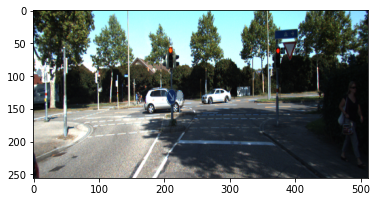

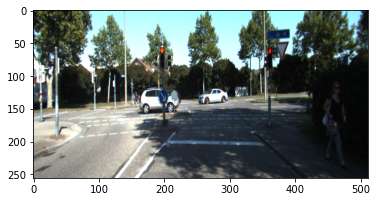

In [28]:
index = 0
for _,_,_, l_img,_,_,_,r_img in val_ds.take(1):
    plt.imshow(l_img[index])
    plt.show()
    plt.imshow(r_img[index])
    plt.show()

In [29]:
pred = model(l_img)

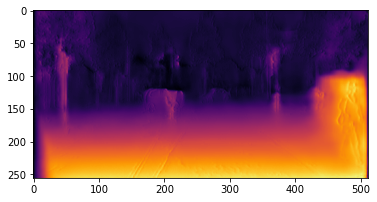

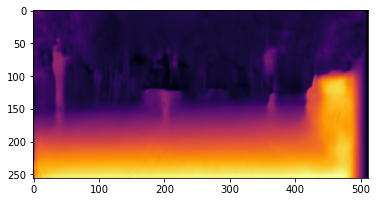

In [30]:
plt.imshow(pred[-1][index,:,:,0], cmap = "inferno")
plt.show()
plt.imshow(pred[-1][index,:,:,1], cmap = "inferno")

In [31]:
pred_right_img= generate_right_image(l_img, tf.expand_dims(pred[3][:,:,:,1], axis = 0))

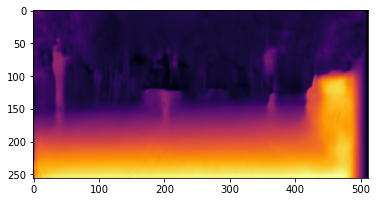

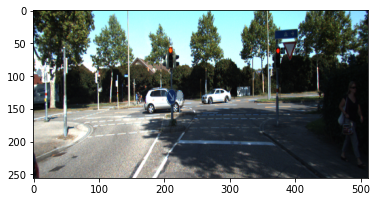

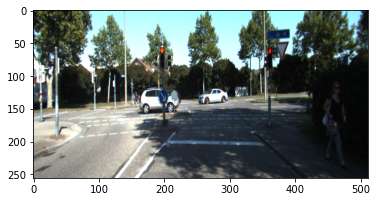

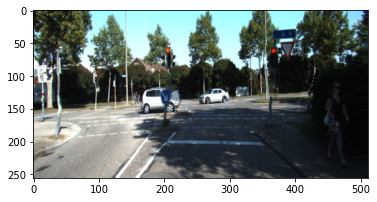

In [32]:
plt.imshow(pred[-1][0,:,:,1], cmap = "inferno")
plt.show()
plt.imshow(l_img[0,:,:,:])
plt.show()
plt.imshow(r_img[0,:,:,:])
plt.show()

plt.imshow(pred_right_img[0,:,:,:])

In [33]:
result = tf.expand_dims(pred[3][index,:,:,0], axis = 2)
result = tf.image.resize(result, (375, 1242))
result.shape
result_depth = 0.54 * 721 / (1242 * result) 

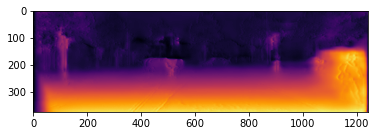

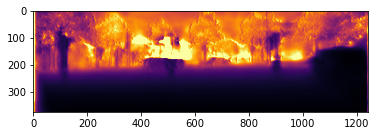

In [34]:
plt.imshow(result, cmap = "inferno")
plt.show()
plt.imshow(result_depth, cmap = "inferno", vmax = 80)
plt.show()

In [96]:
for _,_,_,left_img,_,_,_,right_img in val_ds.take(1):
    pred = model(left_img, training=False)

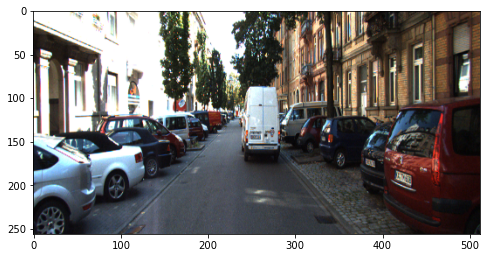

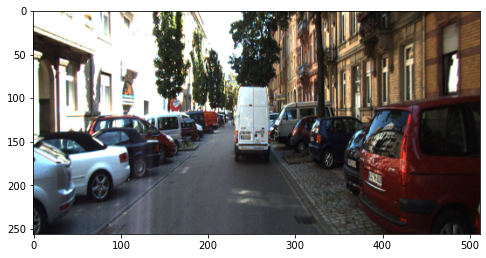

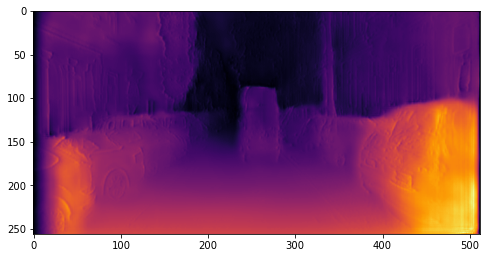

In [97]:
plt.figure(figsize=(8, 8))
plt.imshow(left_img[0])
plt.show()
plt.figure(figsize=(8, 8))
plt.imshow(right_img[0])
plt.show()
plt.figure(figsize=(8, 8))
plt.imshow(pred[-1][0,:,:,0], cmap = "inferno")
plt.show()